![ewatercycle logo](https://raw.githubusercontent.com/eWaterCycle/ewatercycle/main/docs/examples/logo.png)

# Brute force irrigation experiment

This example notebook shows how the eWaterCycle system can be used to quickly assess the impact of irrigation on river discharge. We will manually overwrite the soil moisture values in an experiment with the PCRGlobWB model, to mimick the effect on irrigation. Obviously, this is not a realistic scenario - the eWaterCycle developers are not accountable for any consequences of implementing a real irrigation system after this example.

In [1]:
# This cell is only used to suppress some distracting output messages
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from cartopy import crs
from cartopy import feature as cfeature

import ewatercycle.models
import ewatercycle.parameter_sets

We will run 2 versions of the same model:
1. A reference run with the default setup
2. An irrigation experiment where we will overwrite soil moisture values

We will set up the models with identical parameters and settings. We will use a standard dataset with global parameters on 5 and 30 minutes resolution. The example parameter sets also include forcing data.

In [3]:
merrimack_parameterset = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory="/mnt/data/examples/technical_paper/pcr-globwb/input",
    config="./pcrglobwb_merrimack.ini",
    target_model="pcrglobwb",
    doi="10.5281/zenodo.1045339",
    supported_model_versions={"setters"},
)

print(merrimack_parameterset)

Parameter set
-------------
name=custom_parameter_set
directory=/mnt/data/examples/technical_paper/pcr-globwb/input
config=/mnt/home/user37/ewatercycle/docs/examples/pcrglobwb_merrimack.ini
doi=10.5281/zenodo.1045339
target_model=pcrglobwb
supported_model_versions={'setters'}


We'll track a grid cell nearby a GRDC station with the following coordinates:

In [4]:
grdc_latitude = 42.6459
grdc_longitude = -71.2984

## Reference experiment

For the purpose of illustration, we start by running the reference experiment. Then, in the irrigation experiment, we can focus on the differences with respect to the reference experiment.

In [5]:
# Instantiate the model instance
reference = ewatercycle.models.PCRGlobWB(
    version="setters", parameter_set=merrimack_parameterset
)

# Create experiment folder, set up the model configuration,
# and start the container in which the model will run
reference_config, reference_dir = reference.setup()

Initialize the model inside the container.
Depending on your system this may take a few minutes, 
log messages will start to appear in the output directory


In [6]:
reference.initialize(reference_config)

Create an empty dataframe to store the modelled discharge

In [7]:
time = pd.date_range(reference.start_time_as_isostr, reference.end_time_as_isostr)
timeseries = pd.DataFrame(
    index=pd.Index(time, name="time"), columns=["reference", "experiment"]
)
timeseries.head()

,reference,experiment
time,,
2002-01-01 00:00:00+00:00,NaN,NaN
2002-01-02 00:00:00+00:00,NaN,NaN
2002-01-03 00:00:00+00:00,NaN,NaN
2002-01-04 00:00:00+00:00,NaN,NaN
2002-01-05 00:00:00+00:00,NaN,NaN


In [8]:
while reference.time < reference.end_time:

    reference.update()

    # Track discharge at station location
    discharge_at_station = reference.get_value_at_coords(
        "discharge", lat=[grdc_latitude], lon=[grdc_longitude]
    )
    time = reference.time_as_isostr
    timeseries["reference"][time] = discharge_at_station[0]

    # Show progress
    print(time, end="\r")  # "\r" clears the output before printing the next timestamp

### Intermediate insights

Before we continue with the experiment, let's have a look at the intermediate results. First of all, notice that the reference column in our timeseries dataframe has been filled.

In [9]:
timeseries.head()

,reference,experiment
time,,
2002-01-01 00:00:00+00:00,71.991348,NaN
2002-01-02 00:00:00+00:00,78.788757,NaN
2002-01-03 00:00:00+00:00,79.178329,NaN
2002-01-04 00:00:00+00:00,79.046112,NaN
2002-01-05 00:00:00+00:00,78.232491,NaN


We can also make a map of discharge at the last model step

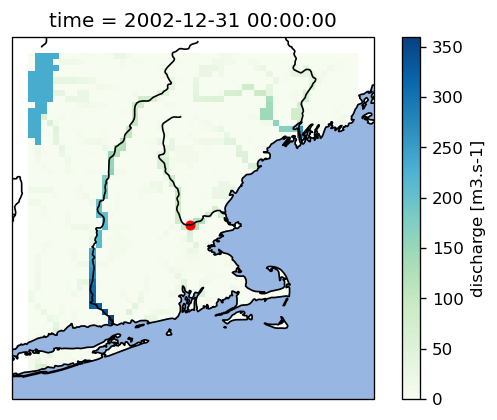

In [10]:
# Use matplotlib to make the figure slightly nicer
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection=crs.PlateCarree())

# Plotting the model field is a one-liner
reference.get_value_as_xarray("discharge").plot(ax=ax, cmap="GnBu")

# Also plot the station location
ax.scatter(grdc_longitude, grdc_latitude, s=25, c="r")

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN, zorder=2)
ax.add_feature(cfeature.RIVERS, zorder=2, color="k")
ax.coastlines(zorder=3)

You can see that the grdc location indeed represents a cell that we would identify as a river.

We can also have a quick look at the discharge timeseries we have tracked, to see if it makes any sense.

<AxesSubplot:xlabel='time'>

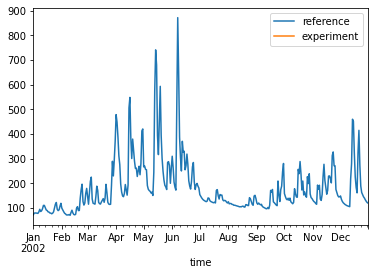

In [11]:
timeseries.plot()

## Running the irrigation experiment

Before we initialize the experiment, let's use the reference model to illustrate the concept of what we will do.

We will fetch the soil moisture field and overwrite a part of it so that the soil will be fully saturated.

In [12]:
soil_moisture = reference.get_value_as_xarray("upper_soil_saturation_degree")

# Copy the field and manually overwrite a random part of the domain
irrigated_soil_moisture = soil_moisture.copy()
irrigated_soil_moisture[31:41, 18:28] = 1

Let's visualize the difference

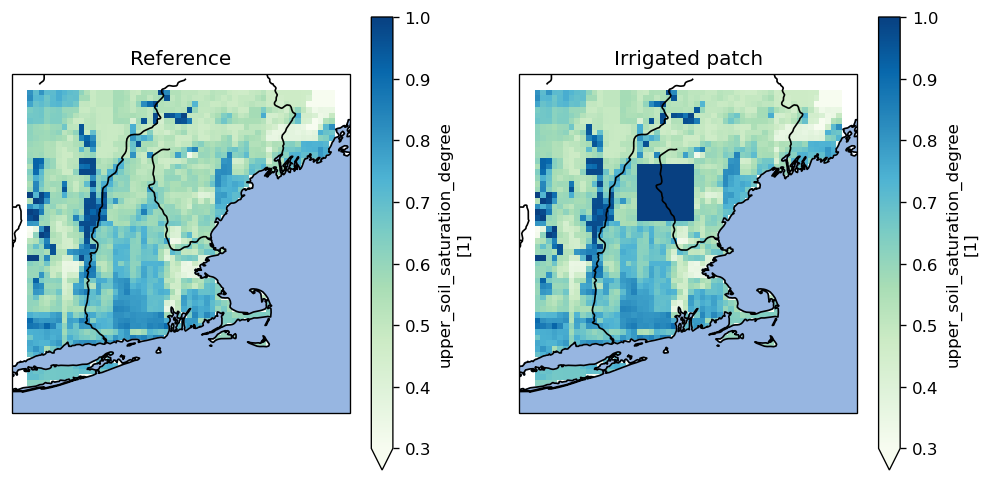

In [13]:
fig = plt.figure(figsize=(10, 5), dpi=120)
left_axes = fig.add_subplot(121, projection=crs.PlateCarree())
right_axes = fig.add_subplot(122, projection=crs.PlateCarree())

soil_moisture.plot(ax=left_axes, cmap="GnBu", vmin=0.3, vmax=1)
irrigated_soil_moisture.plot(ax=right_axes, cmap="GnBu", vmin=0.3, vmax=1)

# Decoration
left_axes.set_title("Reference")
right_axes.set_title("Irrigated patch")

for axes in [left_axes, right_axes]:
    axes.add_feature(cfeature.OCEAN, zorder=2)
    axes.add_feature(cfeature.RIVERS, zorder=2, color="k")
    axes.coastlines(zorder=3)

From here on we will do exactly the same as before, except that we'll add three extra lines to overwrite soil moisture at every time step.

In [14]:
experiment = ewatercycle.models.PCRGlobWB(
    version="setters", parameter_set=merrimack_parameterset
)
experiment_config, experiment_dir = experiment.setup()

In [15]:
experiment.initialize(experiment_config)
# this may take a few minutes, log messages will start to appear in the output directory.

In [16]:
while experiment.time < experiment.end_time:

    experiment.update()

    # Overwrite soil moisture field
    soil_moisture = experiment.get_value_as_xarray(
        "upper_soil_saturation_degree",
    )
    soil_moisture[31:41, 18:28] = 1
    experiment.set_value("upper_soil_saturation_degree", soil_moisture.values.flatten())

    # Track discharge at station location
    discharge_at_station = experiment.get_value_at_coords(
        "discharge", lat=[grdc_latitude], lon=[grdc_longitude]
    )
    time = experiment.time_as_isostr
    timeseries["experiment"][time] = discharge_at_station[0]

    # Show progress
    print(time, end="\r")  # "\r" clears the output before printing the next timestamp

## Final analysis

Text(0.5, 1.0, 'Increased discharge due to irrigation')

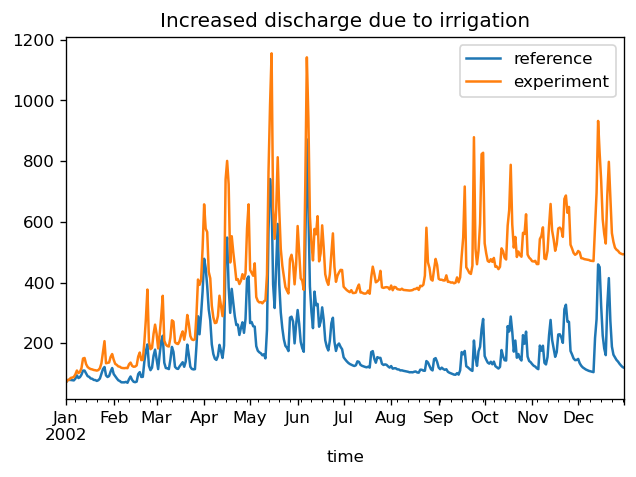

In [17]:
fig, ax = plt.subplots(dpi=120)
timeseries.plot(ax=ax)
ax.set_title("Increased discharge due to irrigation")

## Clean up

It is good practice to remove model instances once you're done with an experiment. This will free up resources on the system.

In [18]:
reference.finalize()
experiment.finalize()